In [3]:
import os
import re
import tqdm
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from unidecode import unidecode
from multiprocessing import Pool
from sklearn.feature_extraction.text import TfidfVectorizer

year = '2020'
os.makedirs('info', exist_ok=True)

def get_score(row):
    score = row.stars if not row.stars == '' else 0
    if len(row['github']) > 0:
        score += 0.5
    return score

def get_paper_info():
    print('Getting paper info...')
    info = {}
    base_url = 'http://openaccess.thecvf.com/CVPR%s.py' % year
    soup = BeautifulSoup(requests.get(base_url).content, "html.parser")
    for a in tqdm.tqdm(soup.find_all('a')):
        link = a.get('href')
        if link is None or link[-5:] != '.html':
            continue
        link = "http://openaccess.thecvf.com/{}".format(a.get('href'))
        paper = BeautifulSoup(requests.get(link).content, "html.parser")
        title = unidecode(paper.find('div', {'id': 'papertitle'}).text.lstrip())
        authors = unidecode(paper.find('i').text).split(',  ')
        abstract = unidecode(paper.find('div', {'id': 'abstract'}).text.strip())
        info[title.lower()] = {'authors': authors, 'abstract': abstract, 'title': title}
    return info

def get_row(row):
    return {'author': row['authors'][0],
        'github': row['github'] if 'github' in row else '',
        'stars': row['stars'] if 'stars' in row else '',
        'task 1': row['tasks'][0] if 'stars' in row and row['tasks'][0] is not None else '',
        'task 2': row['tasks'][1] if 'stars' in row and row['tasks'][1] is not None else '',
        'task 3': row['tasks'][2] if 'stars' in row and row['tasks'][2] is not None else '',
        'title': row['title'],
        }


def get_github(rowi):
    row = info[rowi]
    # print(row)
    url = 'https://paperswithcode.com/search?q={}'.format(row['title'].replace(' ', '+'))
    results = BeautifulSoup(requests.get(url).content, 'html.parser')
    has_code = []
    for res in results.find_all('div', {'class': 'infinite-item'}):
        link = res.find('a', {'class': 'badge-dark'})
        if unidecode(link.text.strip()) == 'Code':
            has_code.append('https://paperswithcode.com{}'.format(link.get('href')))
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform([row['abstract']]).A
    Y = []
    papers = []
    tasks = np.empty(5, dtype=object)
    for link in has_code:
        paper = BeautifulSoup(requests.get(link).content, 'html.parser')
        papers.append(paper)
        paperabs = unidecode(paper.find('div', {'class': 'paper-abstract'}).find('p').text.strip().replace('\n', ' ').replace('...', ' ').replace(' (read more)', ''))
        Y.append(paperabs)

        results = paper.find('div', {'class': 'col-md-5 paper-section'}).find('div', {'class': 'paper-section-title'}).find('div', {'class': 'paper-tasks'}).find_all('ul', {'class':'list-unstyled'})
        for idx, tmp in enumerate(results):
            task = tmp.find('a').get('href').split('/')[-1]
            tasks[idx] = task

    if len(Y) > 0:
        Y = vectorizer.transform(Y).A
        scores = np.matmul(Y, X.T)[:,0]
        best_ix = np.argmax(scores)
        if scores[best_ix] > .85:
            paper = papers[best_ix]
            code = paper.find('div', {'class': 'paper-implementations'}).find('div', {'class': 'row'})
            github = code.find('a', {'class': 'code-table-link'}).get('href')
            stars = int(unidecode(code.find_all('div', {'class': 'paper-impl-cell'})[1].text).strip().replace(' ', '').replace(',', ''))
            return rowi, {'github': github, 'stars': stars, 'tasks': tasks}
 
    return rowi, {}

def get_scholar(rowi):
    row = info[rowi]   
    
    proxies = {"http": "http://127.0.0.1:{}/".format(proxy), "https": "http://127.0.0.1:{}/".format(proxy)}
    url = 'https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q={}'.format(row['title'].replace(' ', '+'))
    content = requests.get(url, proxies=proxies).content.decode('latin-1')
    search_reference_rates = re.findall('Cited by .*?</a>', content, re.MULTILINE)
    reference_rates = []
    for search_reference_rate in search_reference_rates:
        if search_reference_rate:
            search_reference_rate_id_start = 9
            search_reference_rate_id_end = search_reference_rate.find('<')
            reference_rate = search_reference_rate[search_reference_rate_id_start:search_reference_rate_id_end]
            print('reference_rate:', reference_rate)
            reference_rates.append(reference_rate)
    return rowi, {'reference_rate': reference_rates}     

## Step 1. Get paper information

In [4]:
paper_info_filename = os.path.join('cache', 'CVPR%s_paper_info.npy' % year)
try:
    info = np.load(paper_info_filename, allow_pickle=True).tolist()
    print('Load paper information for CVPR %s successfully' % year)
except:
    info = get_paper_info()
    np.save(paper_info_filename, info)
    print('Save paper information for CVPR %s successfully' % year)

Load paper information for CVPR 2020 successfully


## Step 2. Get github information

In [5]:
print('Getting github info...')
github_info_filename = os.path.join('cache', 'CVPR%s_github_info.npy' % year)
try:
    github_info = np.load(github_info_filename, allow_pickle=True).tolist()
    print('Load github information for CVPR %s successfully' % year)
except:
    github_info = {}
#     tmp = list(info.keys())[:20]
    for key in tqdm.tqdm(info.keys()):
        try:
            row, single_info = get_github(key)
            github_info[row] = single_info
        except:
            print('Failed in paper:', key)
    np.save(github_info_filename, github_info)
    print('Save github information for CVPR %s successfully' % year)

Getting github info...
Load github information for CVPR 2020 successfully


In [6]:
for k, val in github_info.items():
    info[k].update(val)

## Step 3. Save to csv files

In [7]:
list(info.items())[0]

('unsupervised learning of probably symmetric deformable 3d objects from images in the wild',
 {'abstract': 'We propose a method to learn 3D deformable object categories from raw single-view images, without external supervision. The method is based on an autoencoder that factors each input image into depth, albedo, viewpoint and illumination. In order to disentangle these components without supervision, we use the fact that many object categories have, at least in principle, a symmetric structure. We show that reasoning about illumination allows us to exploit the underlying object symmetry even if the appearance is not symmetric due to shading. Furthermore, we model objects that are probably, but not certainly, symmetric by predicting a symmetry probability map, learned end-to-end with the other components of the model. Our experiments show that this method can recover very accurately the 3D shape of human faces, cat faces and cars from single-view images, without any supervision or a 

In [8]:
info_result = map(get_row, info.values())
df = pd.DataFrame(info_result)
df['score'] = df.apply(get_score, axis=1)
df = df.sort_values(['score', 'github'], ascending=False)
df = df[['title', 'author', 'task 1', 'task 2', 'task 3', 'github', 'stars']]
df.index = range(1, len(df) + 1)
outname = os.path.join('info', 'CVPR%s_info.csv' % year)
print('Saving to ', outname)
df.to_csv(outname)

Saving to  info/CVPR2020_info.csv


In [9]:
df

,title,author,task 1,task 2,task 3,github,stars
1,Context R-CNN: Long Term Temporal Context for ...,Sara Beery,object-detection,video-understanding,,https://github.com/tensorflow/models/tree/mast...,64576
2,MnasFPN: Learning Latency-Aware Pyramid Archit...,Bo Chen,object-detection,,,https://github.com/tensorflow/models/tree/mast...,64576
3,Google Landmarks Dataset v2 - A Large-Scale Be...,Tobias Weyand,image-retrieval,transfer-learning,,https://github.com/tensorflow/models/tree/mast...,64576
4,PointRend: Image Segmentation As Rendering,Alexander Kirillov,semantic-segmentation,,,https://github.com/facebookresearch/detectron2...,11147
5,Distilling Effective Supervision From Severe L...,Zizhao Zhang,image-classification,,,https://github.com/google-research/google-rese...,10588
6,Bridging the Gap Between Anchor-Based and Anch...,Shifeng Zhang,object-detection,,,https://github.com/open-mmlab/mmdetection,10263
7,Analyzing and Improving the Image Quality of S...,Tero Karras,image-generation,,,https://github.com/NVlabs/stylegan2,4713
8,SpineNet: Learning Scale-Permuted Backbone for...,Xianzhi Du,instance-segmentation,architecture-search,object-detection,https://github.com/tensorflow/tpu/tree/master/...,3585
9,Self-Training With Noisy Student Improves Imag...,Qizhe Xie,data-augmentation,image-classification,,https://github.com/tensorflow/tpu/tree/master/...,3582
10,EfficientDet: Scalable and Efficient Object De...,Mingxing Tan,object-detection,object-detection-in-aerial-images,pedestrian-detection,https://github.com/zylo117/Yet-Another-Efficie...,3441


## 4. Topics anaysis

In [10]:
topics_list = df['task 1'].tolist() + df['task 2'].tolist() + df['task 3'].tolist()
all_topics= set(topics_list)
all_topics

{'',
 '3d-absolute-human-pose-estimation',
 '3d-face-reconstruction',
 '3d-human-action-recognition',
 '3d-human-pose-estimation',
 '3d-instance-segmentation-1',
 '3d-multi-object-tracking',
 '3d-object-classification',
 '3d-object-detection',
 '3d-object-detection-from-stereo-images',
 '3d-object-reconstruction',
 '3d-object-reconstruction-from-a-single-image',
 '3d-pose-estimation',
 '3d-reconstruction',
 '3d-semantic-instance-segmentation',
 '3d-semantic-segmentation',
 '3d-shape-analysis',
 '3d-shape-recognition',
 '3d-shape-reconstruction',
 '3d-shape-representation',
 '3d-shape-retrieval',
 '6d-pose-estimation',
 '6d-pose-estimation-1',
 'action-classification',
 'action-detection',
 'action-localization',
 'action-recognition',
 'action-recognition-in-videos',
 'action-segmentation',
 'action-spotting',
 'active-learning',
 'adversarial-attack',
 'adversarial-defense',
 'anomaly-detection',
 'architecture-search',
 'autonomous-driving',
 'autonomous-navigation',
 'autonomous-veh

In [11]:
from collections import Counter
import matplotlib.pyplot as plt
keyword_counter = Counter(topics_list)

In [12]:
topic_count = pd.DataFrame([(ele, keyword_counter[ele]) for ele in keyword_counter], columns=['topic', 'count']).sort_values(by=['count'], ascending=False)
topic_count.to_csv(os.path.join('info', 'CVPR%s_topic_count.csv' % year))
topic_count

,topic,count
8,,3443
0,object-detection,57
2,semantic-segmentation,49
3,image-classification,32
4,image-generation,26
83,pose-estimation,25
5,instance-segmentation,22
61,architecture-search,20
57,optical-flow-estimation,17
1,image-retrieval,16


In [13]:
keyword_counter['image-super-resolution']

9

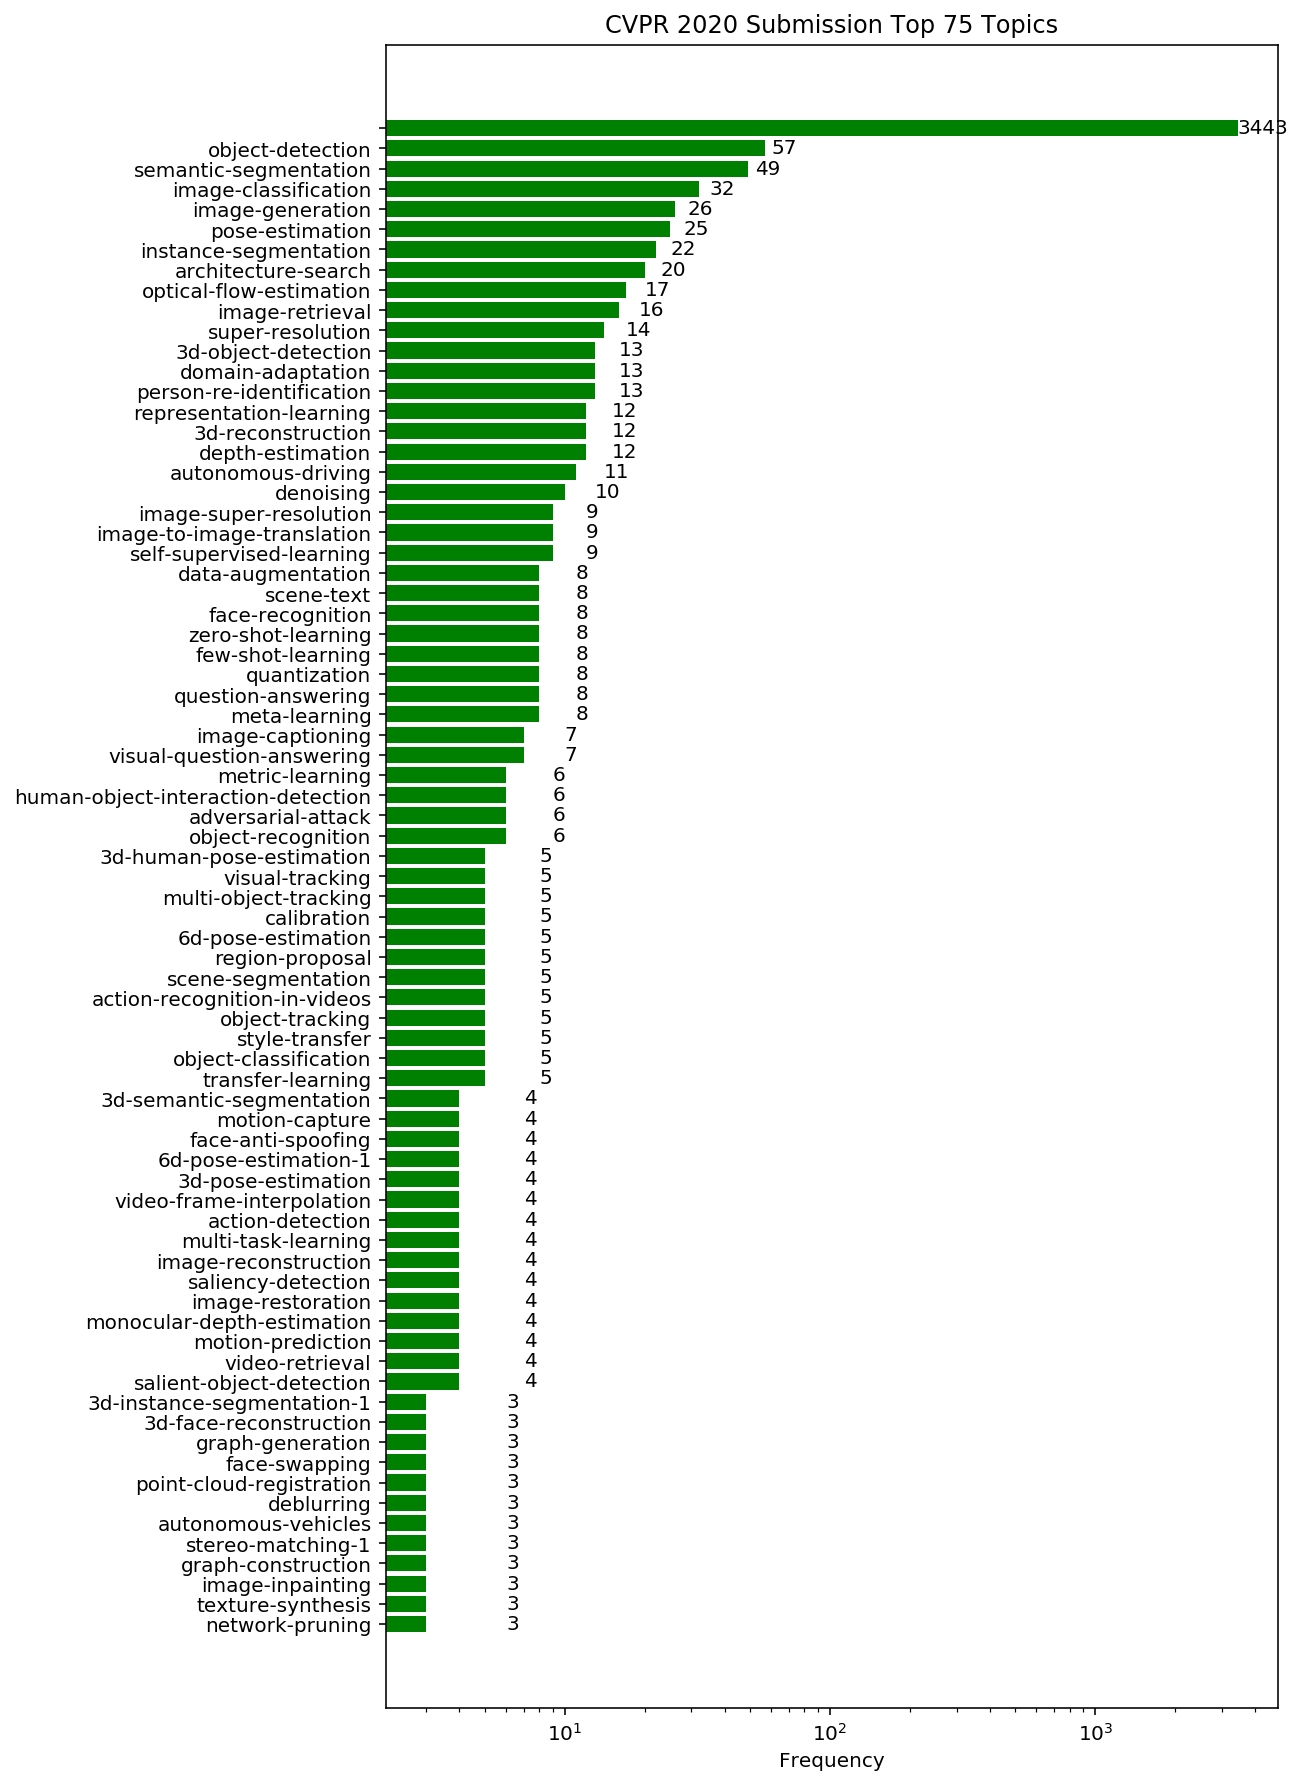

In [28]:
# Show N most common keywords and their frequencies
num_keyowrd = 75
keywords_counter_vis = keyword_counter.most_common(num_keyowrd)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, num_keyowrd//5), dpi=144)

key = [k[0] for k in keywords_counter_vis] 
value = [k[1] for k in keywords_counter_vis] 
y_pos = np.arange(len(key))
ax.barh(y_pos, value, align='center', color='green', ecolor='black', log=True)
ax.set_yticks(y_pos)
ax.set_yticklabels(key, rotation=0, fontsize=10)
ax.invert_yaxis() 
for i, v in enumerate(value):
    ax.text(v + 3, i + .25, str(v), color='black', fontsize=10)
# ax.text(y_pos, value, str(value))
ax.set_xlabel('Frequency')
ax.set_title('CVPR %s Submission Top %d Topics' % (year, num_keyowrd))

plt.savefig(os.path.join('info', 'CVPR%s_topics.png' % year), bbox_inches='tight', pad_inches=0)
plt.show()

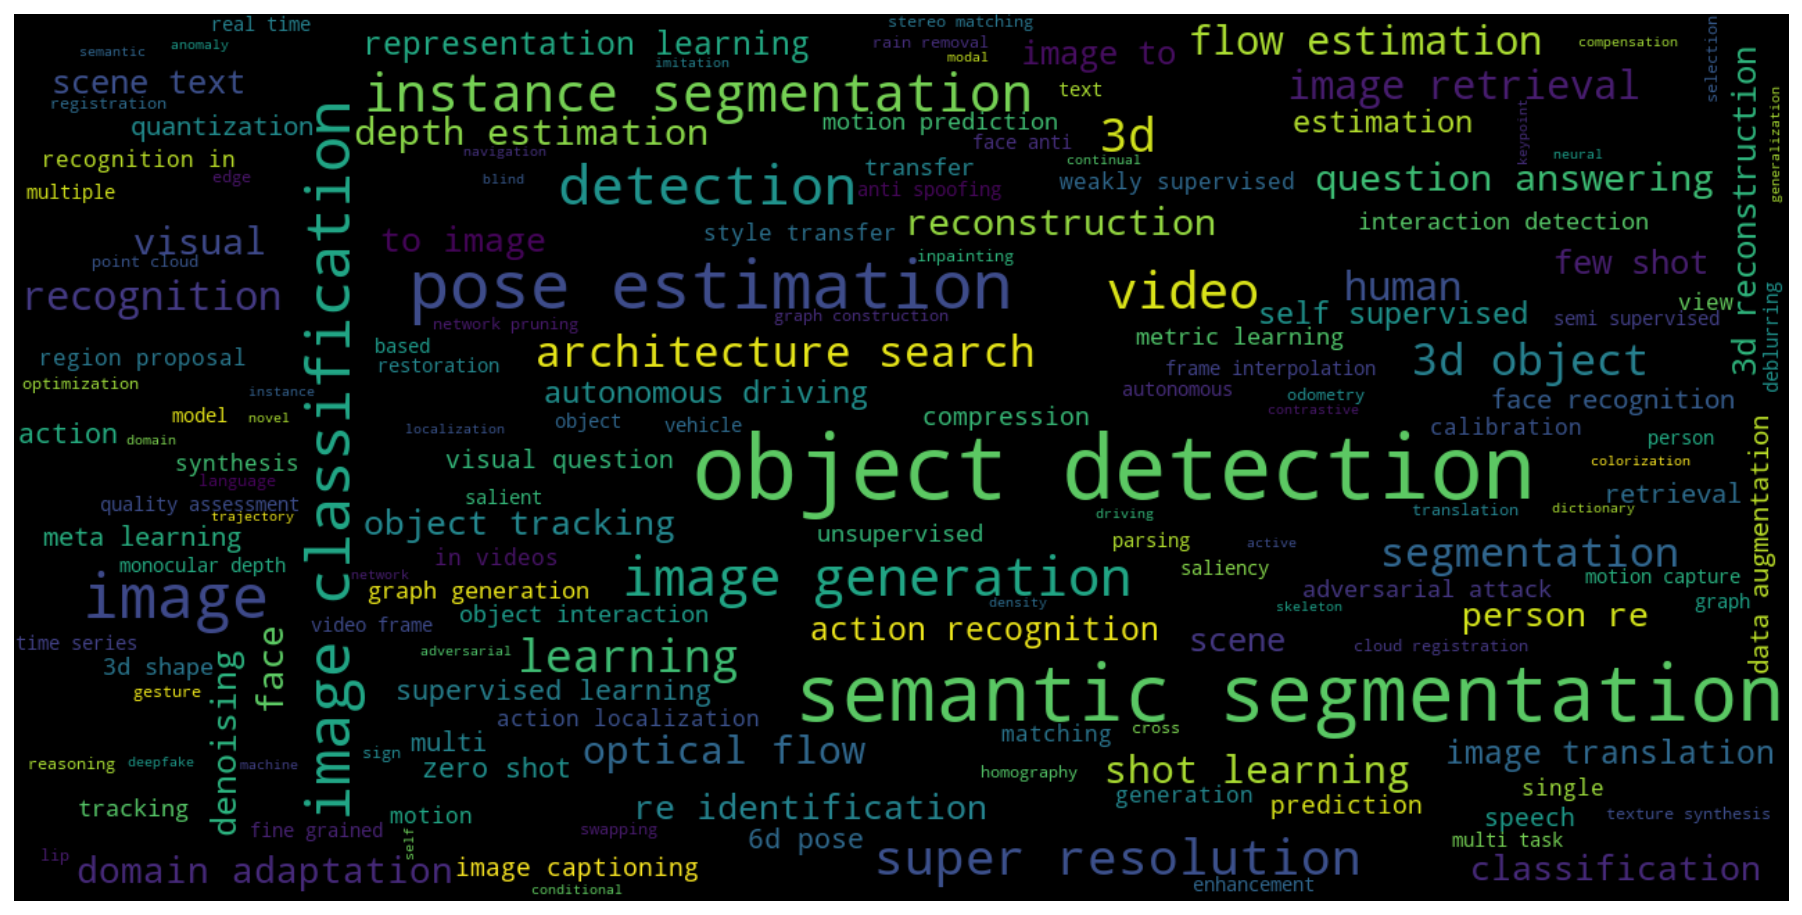

In [29]:
# Show the word cloud forming by keywords
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=64, max_words=160, 
                      width=1280, height=640,
                      background_color="black").generate(' '.join(topics_list))
plt.figure(figsize=(16, 8), dpi=144)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(os.path.join('info', 'CVPR%s_wordcloud.png' % year), bbox_inches='tight', pad_inches=0)
plt.show()

## Search papers according to keyword and topic

In [30]:
def pull_papers(paper_infos, topics, search_range='all'):
    target_title = pd.DataFrame()
    for topic in topics:
        tmp = paper_infos[paper_infos['title'].str.contains(topic.capitalize())]
        target_title = pd.concat([target_title, tmp]).drop_duplicates()

    target_topic = pd.DataFrame()
    for topic in topics:
        for i in range(3):
            tmp = paper_infos[paper_infos['task %d' % (i+1)].str.contains(topic)]
            target_topic = pd.concat([target_topic, tmp]).drop_duplicates()

    if search_range == 'title':
        return target_title
    elif search_range == 'topic':
        return target_topic
    elif search_range == 'all':
        return pd.concat([target_title, target_topic]).drop_duplicates()   


In [31]:
pull_papers(df, ['denoising'])

,title,author,task 1,task 2,task 3,github,stars
127,FastDVDnet: Towards Real-Time Deep Video Denoi...,Matias Tassano,denoising,motion-compensation,motion-estimation,https://github.com/m-tassano/fastdvdnet,102
172,A Physics-Based Noise Formation Model for Extr...,Kaixuan Wei,denoising,image-denoising,,https://github.com/Vandermode/NoiseModel,75
238,Supervised Raw Video Denoising With a Benchmar...,Huanjing Yue,denoising,image-denoising,video-denoising,https://github.com/cao-cong/RViDeNet,49
339,Transfer Learning From Synthetic to Real-Noise...,Yoonsik Kim,denoising,transfer-learning,,https://github.com/terryoo/AINDNet,25
684,Event Probability Mask (EPM) and Event Denoisi...,R. Wes Baldwin,,,,,
693,Self2Self With Dropout: Learning Self-Supervis...,Yuhui Quan,,,,,
721,Joint Demosaicing and Denoising With Self Guid...,Lin Liu,,,,,
804,Memory-Efficient Hierarchical Neural Architect...,Haokui Zhang,,,,,
1285,Basis Prediction Networks for Effective Burst ...,Zhihao Xia,,,,,
130,CycleISP: Real Image Restoration via Improved ...,Syed Waqas Zamir,denoising,image-denoising,image-restoration,https://github.com/swz30/CycleISP,98


## Classify topic

In [32]:
topic_class = pd.read_excel('topic_class.xlsx')

In [33]:
topic_class

,a,b,c,d,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,e
0,pose-estimation,object-detection,image-retrieval,traffic-sign-recognition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,traffic-sign-recognition
1,3d-object-detection,semantic-segmentation,image-classification,robust-speech-recognition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,robust-speech-recognition
2,3d-reconstruction,image-classification,optical-flow-estimation,face-clustering,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,face-clustering
3,depth-estimation,image-generation,video-recognition,scene-text-recognition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,scene-text-recognition
4,human-object-interaction-detection,instance-segmentation,super-resolution,lip-to-speech-synthesis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lip-to-speech-synthesis
5,action-recognition-in-videos,super-resolution,denoising,fine-grained-vehicle-classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fine-grained-vehicle-classification
6,6d-pose-estimation,person-re-identification,image-to-image-translation,latent-variable-models,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,latent-variable-models
7,calibration,domain-adaptation,image-super-resolution,face-hallucination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,face-hallucination
8,3d-human-pose-estimation,representation-learning,self-supervised-learning,face-detection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,video-recognition
9,visual-tracking,image-super-resolution,image-captioning,speech-enhancement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,face-detection


In [34]:
def count_class_topic(topic_class, target_class):
    target_keyword = []
    topics = list(topic_class[target_class])
    clean_topics = [x for x in topics if str(x)!='nan']
    num_keyowrd = len(clean_topics)
    print('num_keyowrd of %s is:%d' % (target_class, num_keyowrd))
    for x in clean_topics:
        target_keyword.extend([x]*keyword_counter[x])

    target_keyword_counter = Counter(target_keyword)

    # Show N most common keywords and their frequencies
    keywords_counter_vis = target_keyword_counter.most_common(num_keyowrd)

    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(8, num_keyowrd//5), dpi=144)

    key = [k[0] for k in keywords_counter_vis] 
    value = [k[1] for k in keywords_counter_vis] 
    y_pos = np.arange(len(key))
    ax.barh(y_pos, value, align='center', color='green', ecolor='black', log=True)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(key, rotation=0, fontsize=10)
    ax.invert_yaxis() 
    for i, v in enumerate(value):
        ax.text(v + 3, i + .25, str(v), color='black', fontsize=10)

    ax.set_xlabel('Frequency')
    ax.set_title('Topic of class %s' % (target_class))

    plt.savefig(os.path.join('info', 'Topic of class %s.png') % (target_class.upper()), bbox_inches='tight', pad_inches=0)
    plt.close()

In [35]:
count_class_topic(topic_class, 'a')
count_class_topic(topic_class, 'b')
count_class_topic(topic_class, 'c')
count_class_topic(topic_class, 'd')

num_keyowrd of a is:90
num_keyowrd of b is:64
num_keyowrd of c is:66
num_keyowrd of d is:50


In [36]:
def get_and_save(target_class):
    topics = list(topic_class[target_class])
    clean_topics = [x for x in topics if str(x)!='nan']
    clean_infos = pull_papers(df, clean_topics, 'topic').reset_index(drop=True)
    print('%s have %d papers' % (target_class, len(clean_infos)))
    save_path = os.path.join('info', '%s.csv' % target_class.upper())
    clean_infos.to_csv(save_path)
    return clean_infos

In [37]:
get_and_save('a')

a have 169 papers


,title,author,task 1,task 2,task 3,github,stars
0,VIBE: Video Inference for Human Body Pose and ...,Muhammed Kocabas,3d-human-pose-estimation,3d-pose-estimation,motion-capture,https://github.com/mkocabas/VIBE,1230
1,HigherHRNet: Scale-Aware Representation Learni...,Bowen Cheng,multi-person-pose-estimation,pose-estimation,representation-learning,https://github.com/HRNet/Higher-HRNet-Human-Po...,482
2,HybridPose: 6D Object Pose Estimation Under Hy...,Chen Song,6d-pose-estimation,pose-estimation,,https://github.com/chensong1995/HybridPose,242
3,PVN3D: A Deep Point-Wise 3D Keypoints Voting N...,Yisheng He,6d-pose-estimation-1,keypoint-detection,pose-estimation,https://github.com/ethnhe/PVN3D,142
4,Coherent Reconstruction of Multiple Humans Fro...,Wen Jiang,3d-pose-estimation,3d-reconstruction,instance-segmentation,https://github.com/JiangWenPL/multiperson,98
5,End-to-End Learnable Geometric Vision by Backp...,Bo Chen,6d-pose-estimation-1,6d-pose-estimation,,https://github.com/BoChenYS/BPnP,90
6,The Devil Is in the Details: Delving Into Unbi...,Junjie Huang,pose-estimation,,,https://github.com/HuangJunJie2017/UDP-Pose,76
7,Compressed Volumetric Heatmaps for Multi-Perso...,Matteo Fabbri,3d-human-pose-estimation,3d-pose-estimation,pose-estimation,https://github.com/fabbrimatteo/LoCO,62
8,Generating 3D People in Scenes Without People,Yan Zhang,pose-estimation,,,https://github.com/yz-cnsdqz/PSI-release,48
9,G2L-Net: Global to Local Network for Real-Time...,Wei Chen,6d-pose-estimation-1,6d-pose-estimation,pose-estimation,https://github.com/DC1991/G2L_Net,44


In [38]:
get_and_save('b')

b have 270 papers


,title,author,task 1,task 2,task 3,github,stars
0,Context R-CNN: Long Term Temporal Context for ...,Sara Beery,object-detection,video-understanding,,https://github.com/tensorflow/models/tree/mast...,64576
1,MnasFPN: Learning Latency-Aware Pyramid Archit...,Bo Chen,object-detection,,,https://github.com/tensorflow/models/tree/mast...,64576
2,Bridging the Gap Between Anchor-Based and Anch...,Shifeng Zhang,object-detection,,,https://github.com/open-mmlab/mmdetection,10263
3,EfficientDet: Scalable and Efficient Object De...,Mingxing Tan,object-detection,object-detection-in-aerial-images,pedestrian-detection,https://github.com/zylo117/Yet-Another-Efficie...,3441
4,nuScenes: A Multimodal Dataset for Autonomous ...,Holger Caesar,3d-object-detection,autonomous-driving,autonomous-vehicles,https://github.com/traveller59/second.pytorch,906
5,Self-Supervised Learning of Pretext-Invariant ...,Ishan Misra,object-detection,representation-learning,self-supervised-image-classification,https://github.com/HobbitLong/PyContrast,459
6,Revisiting the Sibling Head in Object Detector,Guanglu Song,object-detection,,,https://github.com/Sense-X/TSD,274
7,Structure Aware Single-Stage 3D Object Detecti...,Chenhang He,3d-object-detection,autonomous-driving,object-detection,https://github.com/skyhehe123/SA-SSD,216
8,Scale-Equalizing Pyramid Convolution for Objec...,Xinjiang Wang,object-detection,,,https://github.com/jshilong/SEPC,210
9,Few-Shot Object Detection With Attention-RPN a...,Qi Fan,few-shot-object-detection,object-detection,,https://github.com/fanq15/Few-Shot-Object-Dete...,205


In [39]:
get_and_save('c')

c have 203 papers


,title,author,task 1,task 2,task 3,github,stars
0,Google Landmarks Dataset v2 - A Large-Scale Be...,Tobias Weyand,image-retrieval,transfer-learning,,https://github.com/tensorflow/models/tree/mast...,64576
1,12-in-1: Multi-Task Vision and Language Repres...,Jiasen Lu,image-retrieval,question-answering,representation-learning,https://github.com/jiasenlu/vilbert_beta,282
2,Cross-Batch Memory for Embedding Learning,Xun Wang,image-retrieval,metric-learning,,https://github.com/MalongTech/research-xbm,38
3,Embedding Expansion: Augmentation in Embedding...,Byungsoo Ko,image-retrieval,metric-learning,,https://github.com/clovaai/embedding-expansion,30
4,Generalized Product Quantization Network for S...,Young Kyun Jang,image-retrieval,metric-learning,quantization,https://github.com/youngkyunJang/GPQ,7
5,Probability Weighted Compact Feature for Domai...,Fuxiang Huang,image-retrieval,quantization,,https://github.com/fuxianghuang1/PWCF,6
6,"Same Features, Different Day: Weakly Supervise...",Jaime Spencer,image-retrieval,,,https://github.com/jspenmar/DejaVu_Features,3
7,Evade Deep Image Retrieval by Stashing Private...,Yanru Xiao,image-retrieval,,,https://github.com/sugarruy/hashstash,1
8,Circle Loss: A Unified Perspective of Pair Sim...,Yifan Sun,face-recognition,image-retrieval,person-re-identification,https://github.com/TinyZeaMays/CircleLoss,201
9,ASLFeat: Learning Local Features of Accurate S...,Zixin Luo,face-recognition,image-retrieval,person-re-identification,https://github.com/lzx551402/ASLFeat,83


In [40]:
get_and_save('d')

d have 87 papers


,title,author,task 1,task 2,task 3,github,stars
0,Universal Litmus Patterns: Revealing Backdoor ...,Soheil Kolouri,traffic-sign-recognition,,,https://github.com/UMBCvision/Universal-Litmus...,6
1,Noise Robust Generative Adversarial Networks,Takuhiro Kaneko,robust-speech-recognition,speech-dereverberation,speech-enhancement,https://github.com/takuhirok/NR-GAN,4
2,Learning to Cluster Faces via Confidence and C...,Lei Yang,connectivity-estimation,face-clustering,,https://github.com/yl-1993/learn-to-cluster,349
3,Towards Accurate Scene Text Recognition With S...,Deli Yu,scene-text,scene-text-recognition,,https://github.com/PaddlePaddle/PaddleOCR,618
4,Learning Individual Speaking Styles for Accura...,K R Prajwal,lip-reading,lip-to-speech-synthesis,speaker-specific-lip-to-speech-synthesis,https://github.com/Rudrabha/Lip2Wav,175
5,Proxy Anchor Loss for Deep Metric Learning,Sungyeon Kim,fine-grained-image-classification,fine-grained-vehicle-classification,metric-learning,https://github.com/tjddus9597/Proxy-Anchor-CVP...,75
6,Adversarial Latent Autoencoders,Stanislav Pidhorskyi,latent-variable-models,representation-learning,style-transfer,https://github.com/podgorskiy/ALAE,2161
7,PULSE: Self-Supervised Photo Upsampling via La...,Sachit Menon,face-hallucination,image-super-resolution,super-resolution,https://github.com/adamian98/pulse,2201
8,Zero-Reference Deep Curve Estimation for Low-L...,Chunle Guo,face-detection,image-enhancement,low-light-image-enhancement,https://github.com/Li-Chongyi/Zero-DCE,49
9,Learning Human-Object Interaction Detection Us...,Tiancai Wang,action-detection,action-localization,spatio-temporal-action-localization,https://github.com/vaesl/IP-Net,17
